<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/Tracking_Datasets.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/Tracking_Datasets.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/Tracking_Datasets.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/Tracking_Datasets.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# WORKING WITH VIDEO AND TRACKING DATASETS IN FIFTYONE

In this tutorial, we’ll work with a video dataset and tackle a pedestrian tracking problem within FiftyOne. Video computer vision datasets require specialized workflows and can present specific challenges for machine learning and analysis. Fortunately, FiftyOne provides native support for video in both the UI and SDK. Let’s dive in and take a look!

We will consider the problem of tracking multiple pedestrians in a street scene. For our dataset, we’ll explore the [Multiple Object Tracking (MOT17) dataset](https://motchallenge.net/) . When it comes time to do some of
our own tracking, we’ll perform two-stage object tracking combining [Yolov8](https://github.com/ultralytics/ultralytics) with [BoT-SORT](https://github.com/NirAharon/BoT-SORT). FiftyOne’s built-in evaluation methods and embeddings view will give us insight into our tracking quality and help us search for identity swaps.

The objectives of this tutorial are Encoding video data in image stacks into FiftyOne-friendly movies
- Loading a video dataset with detections and trajectories into FiftyOne
- Computing, storing, and analyzing per-frame trajectory statistics
- Visualizing interesting object trajectories
- Running a pedestrian tracker on the dataset and loading the results
- Assessing our tracking using FiftyOne’s evaluation methods and embeddings visualization

**So, what’s the takeaway?** As video-enabled devices proliferate, video data will continue to comprise a significant portion of computer vision, with its own workflows and challenges. FiftyOne’s large toolkit provides built-in support, so load up those video datasets!

## Setup

To get started, you need to install [FiftyOne](https://voxel51.com/docs/FiftyOne/getting_started/install.html) :

In [ ]:
!pip install FiftyOne

In [3]:
import os
import numpy as np
import pandas as pd
import fiftyone as fo
import fiftyone.utils.video as fouv
import fiftyone.zoo as foz
import fiftyone.brain as fob
from fiftyone import ViewField as F
print(f'Your FO version is: {fo.__version__}')

Your FO version is: 0.23.0


## Dataset

Download the [data (5.5GB)](https://motchallenge.net/data/MOT17.zip) for the [MOT17 dataset](https://motchallenge.net/data/MOT17/) . This data comprises seven videos with object detections from three different models.

In [ ]:
# Download the data to a data directory
DATA_DIR = os.path.join(os.getcwd(),'mot17data')
!wget -P {DATA_DIR} https://motchallenge.net/data/MOT17.zip

In [ ]:
# Unzip the data
!unzip {os.path.join(DATA_DIR,'MOT17.zip')}

## Encode the Movies

This dataset comes as image stacks. We will encode these image stacks into movies for use with FiftyOne. (In the future, FiftyOne will support image-stacks-as-video natively.)

How movies are encoded is an important consideration when working with video datasets. This is especially true in computer vision, where frame-level consistency in playback and alignment with annotations is crucial. Some encodings may work well on some platforms or with certain software, but not others. In general, it is a good idea to experiment with and test your encodings across all
platforms and software packages used by your team and in your organization.

In [2]:
DATA_DIR = "./MOT17"

In [3]:
# Create a directory to hold encoded movies
mp4_dir = os.path.join(DATA_DIR,'movies')
!mkdir -p {mp4_dir}

FiftyOne provides utilities to [reencode videos](https://docs.voxel51.com/api/FiftyOne.utils.video.html?highlight=reencode#FiftyOne.utils.video.reencode_video) for compatibility with FiftyOne. By default, this re-encoding uses the [ffmpeg](https://ffmpeg.org/) library, which accepts image stacks as input.


In this tutorial, we will encode and work with two of the videos in the MOTS17 dataset.

In [4]:
MOV_NUMS = [2,9]

In [5]:
for movi in MOV_NUMS:
    mov_in = os.path.join(DATA_DIR,'train',f'MOT17-{movi:02}-FRCNN/img1/%06d.jpg')
    mov_out = os.path.join(mp4_dir,f'MOT17-{movi:02}.mp4')
    fouv.reencode_video(mov_in,mov_out)

## Create a FiftyOne Video Dataset

With our video data encoded into movies, it’s a snap to create a video dataset in FiftyOne using the `Dataset.from_dir` function.

Calling `ensure_frames` pre-populates the `.frames` property for every video frame in each sample in the dataset. This is not mandatory, but is useful for being able to easily see how many frames
are contained in each sample.

In [6]:
dataset = fo.Dataset.from_dir(dataset_dir=mp4_dir,dataset_type=fo.types.VideoDirectory)
dataset.ensure_frames()

 100% |█████████████████████| 2/2 [26.4ms elapsed, 0s remaining, 75.8 samples/s]     
Computing metadata...
 100% |█████████████████████| 2/2 [243.2ms elapsed, 0s remaining, 8.2 samples/s] 


Let’s name our dataset and persist it so we can load it next time.

In [7]:
dataset.name = 'mots17'
dataset.persistent = True

Printing the first sample in our dataset shows us metadata for the first video. The frames attribute is an ordered dictionary containing Frame objects keyed by frame number.

In [11]:
sample = dataset.first()
print(sample)

<Sample: {
    'id': '65450ab38d92e9f07dc6ec1f',
    'media_type': 'video',
    'filepath': '/home/dan/Documents/track/MOT17/movies/MOT17-02.mp4',
    'tags': [],
    'metadata': <VideoMetadata: {
        'size_bytes': 19911561,
        'mime_type': 'video/mp4',
        'frame_width': 1920,
        'frame_height': 1080,
        'frame_rate': 25.0,
        'total_frame_count': 600,
        'duration': 24.0,
        'encoding_str': 'avc1',
    }>,
    'frames': <Frames: 600>,
}>


When indexing frames , make sure to use 1-based frame numbers.

In [12]:
print(sample.frames[1])

<Frame: {'id': '65450ab3f3833718570f940b', 'frame_number': 1}>


## Loading Detections

Let’s load some detections! The MOTS17 dataset contains ground truth annotations in csv files for each movie. These annotations include bounding box detections, classes, and identity IDs.

The identity IDs make this problem a tracking problem and not just an object detection problem. Detections must be associated across frames as belonging to a particular individual or trajectory.

The columns in the provided csv files, as well as the list of classes used, are as described in this [paper](https://arxiv.org/abs/1603.00831). We are primarily interested in people, so we set some of the other class labels to “na”. We also replace the “Static person” class with simply “person” as we will not distinguish the two classes here.

In [13]:
GT_COLUMNS = ['frame','id','x0','y0','w','h','flag','class','visibility']
GT_CLASSES = ['na','person','na','na','na','na','vehicle','person', \
'na','na','na','occluded','na','crowd']

def read_detections(df, frame):
    '''
    Parse detections from MOTS17 csv/dataframe
    df: dataframe containing GT detections
    frame: frame (1-based) of interest
    '''
    
    df_frame = df[df.frame==frame]
    bbox_arr = df_frame[ ['x0','y0','w','h'] ].to_numpy().astype(np.float64)
    bboxes = bbox_arr.tolist()
    
    frame_rel = range(0,len(bboxes))
    ids = df_frame['id'].to_list()
    vis = df_frame['visibility'].to_list()
    classes = df_frame['class'].to_list()
    classes = [GT_CLASSES[i] for i in classes]
    return zip(bboxes, ids, vis, classes, frame_rel)

for movi, samp in zip(MOV_NUMS,dataset):
    print(f'Loading gt detections for {samp.filepath}')
    # The ground-truth csv files are located under a particular detection method (like FRCNN),
    # but are identical across the different detection types. We won't actually use the FRCNN detections.
    gt_csv = os.path.join(DATA_DIR,'train',f'MOT17-{movi:02}-FRCNN/gt/gt.txt')
    df_gt = pd.read_csv(gt_csv,names=GT_COLUMNS)
    
    imw = samp.metadata.frame_width
    imh = samp.metadata.frame_height
    df_gt[['x0','w']] /= imw
    df_gt[['y0','h']] /= imh
    
    for frame_no, frame in samp.frames.items():
        dets_gt = []
        for bb, id, vis, cls, frm_rel in read_detections(df_gt, frame_no):
            det = fo.Detection(bounding_box=bb, index=str(id), label=cls, visibility=vis)
            dets_gt.append(det)
            
        frame['gt'] = fo.Detections(detections=dets_gt)
        
        if frame_no % 100 == 0:
            print(f'frame {frame_no}')
            
    samp.save()

Loading gt detections for /home/dan/Documents/track/MOT17/movies/MOT17-02.mp4
frame 100
frame 200
frame 300
frame 400
frame 500
frame 600
Loading gt detections for /home/dan/Documents/track/MOT17/movies/MOT17-09.mp4
frame 100
frame 200
frame 300
frame 400
frame 500


In [4]:
import fiftyone as fo

dataset = fo.load_dataset("mots17")


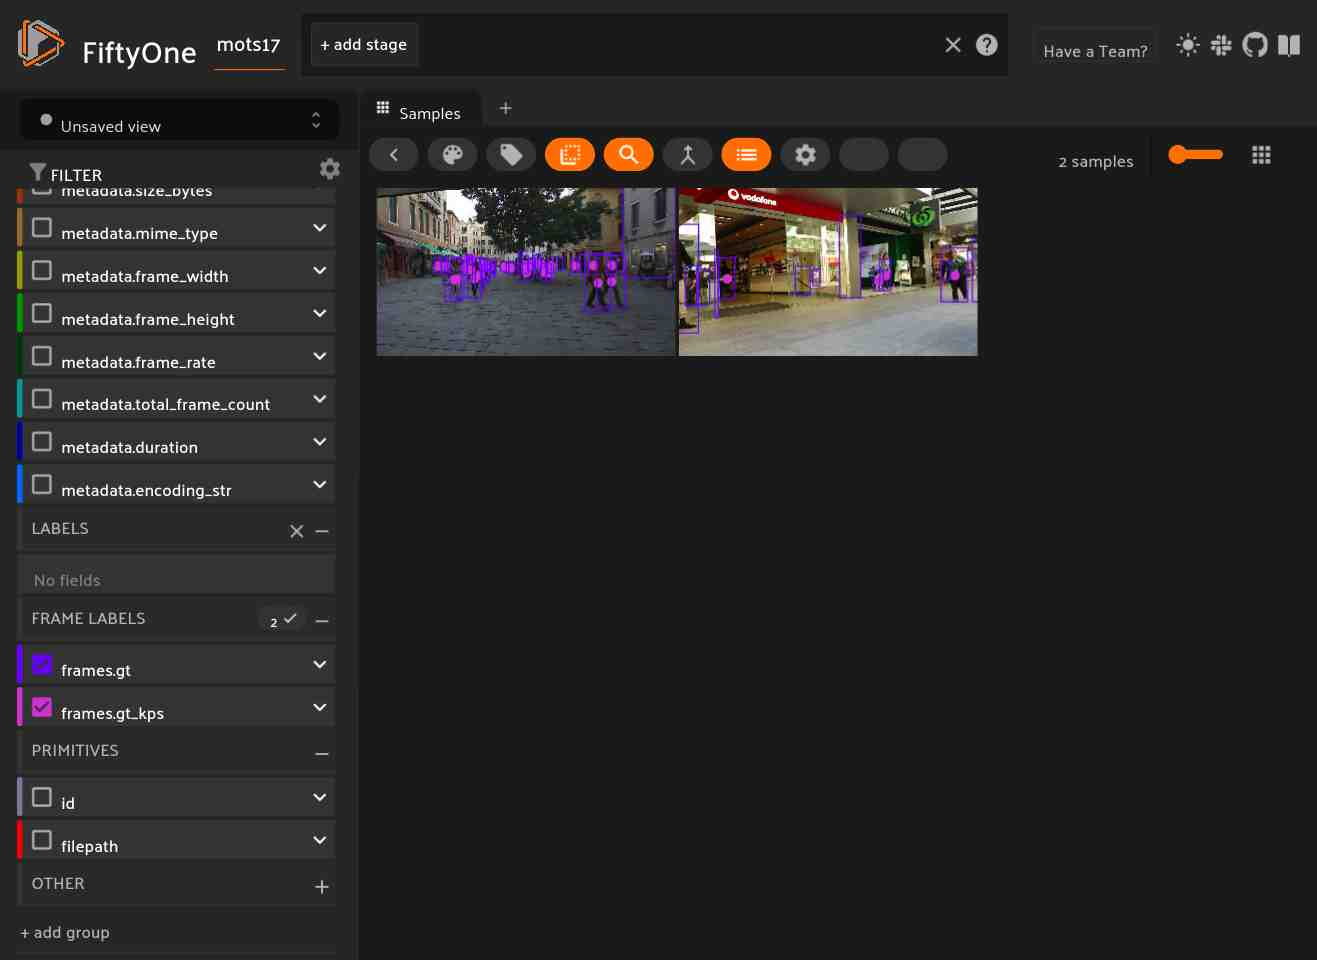

In [5]:
session = fo.launch_app(dataset)

Let’s do some basic exploration of our trajectories. We’ll focus on the first movie by creating a view. The `index` field in our detections captures the trajectory identity; using the `count_values` aggregation gives us a count of the number of frames for each trajectory index:

In [6]:
view = dataset.limit(1)
traj_counts = view.count_values('frames.gt.detections.index')
num_trajs = len(traj_counts)
traj_lens = traj_counts.values()
print(f'There are {num_trajs} trajectories with min/max lengths of {min(traj_lens)}/{max(traj_lens)}')
print(traj_counts)

There are 83 trajectories with min/max lengths of 1/600
{39: 376, 50: 528, 69: 280, 65: 580, 58: 303, 26: 600, 36: 516, 25: 600, 49: 218, 74: 68, 63: 111, 81: 1, 64: 111, 28: 448, 57: 467, 22: 39, 21: 80, 45: 491, 37: 279, 29: 537, 76: 155, 31: 600, 33: 266, 11: 530, 34: 248, 46: 600, 2: 56, 18: 600, 62: 304, 79: 52, 3: 575, 5: 600, 77: 12, 44: 370, 67: 349, 60: 402, 30: 600, 23: 586, 7: 581, 83: 1, 47: 600, 24: 600, 59: 323, 66: 600, 61: 550, 6: 600, 38: 351, 35: 230, 71: 60, 16: 62, 43: 479, 32: 298, 73: 121, 75: 62, 56: 278, 1: 600, 20: 322, 55: 43, 40: 529, 78: 25, 15: 600, 9: 600, 41: 373, 82: 1, 13: 526, 10: 600, 53: 498, 54: 369, 72: 152, 8: 43, 27: 570, 48: 251, 14: 306, 80: 4, 19: 549, 4: 600, 70: 206, 17: 600, 51: 600, 12: 493, 52: 533, 42: 361, 68: 315}


Let’s compute a basic statistic like the speed of a trajectory and add it to our dataset. We’ll compute this speed using the centroid of our detection boxes. We can also add this centroid to our dataset as a keypoint label so that these centroids can be visualized.

We’ll filter our dataset first so that we only perform this computation for the `person` label.

In [7]:
def centroid(bb):
    # Compute the centroid of a FiftyOne-style bounding box (in normalized image coordinates)
    x = bb[0] + bb[2]/2.0
    y = bb[1] + bb[3]/2.0
    return x,y
    
for samp in dataset.filter_labels('frames.gt',F('label')=='person').iter_samples(autosave=True):
    print(f'Working on {samp.filepath}')
    imw = samp.metadata.frame_width
    imh = samp.metadata.frame_height
    last_seen = {}
    for fno,frame in samp.frames.items():
        dets = frame.gt.detections
        kps = [fo.Keypoint(points=[centroid(x.bounding_box)],label=x.label,index=x.index) for x in dets]
        for kp in kps:
            if fno>1 and kp.index in last_seen:
                pts0 = last_seen[kp.index]
                pts1 = kp.points[0]
                dx_px = imw * (pts1[0]-pts0[0])
                dy_px = imh * (pts1[1]-pts0[1])
                vel = np.hypot( dx_px, dy_px )
                kp['speed'] = vel
            else:
                kp['speed'] = None
                
        last_seen = {x.index: x.points[0] for x in kps}
        frame['gt_kps'] = fo.Keypoints(keypoints=kps)
        frame.save()
        
        if fno % 100 ==0:
            print(f' frame {fno}')

Working on /home/dan/Documents/track/MOT17/movies/MOT17-02.mp4
 frame 100
 frame 200
 frame 300
 frame 400
 frame 500
 frame 600
Working on /home/dan/Documents/track/MOT17/movies/MOT17-09.mp4
 frame 100
 frame 200
 frame 300
 frame 400
 frame 500


To visualize our new frame-level field `speed` in the FiftyOne App, let’s call `add_dynamic_frame_fields` on our dataset. This adds `speed` to our dataset’s schema.

In [ ]:
dataset.add_dynamic_frame_fields()
session.dataset = dataset

We can now filter by `speed` in the sidebar for visualization of detection centroids. We can also view a histogram of speeds across all frames.

With the per-frame speeds saved on our detections, we can compute statistics like the average or maximum speed for each individual. To this, we’ll filter for each trajectory and use the `values` aggregation to obtain a list of speeds over all frames in its lifetime.

Who’s moving quickly and who’s moving slowly? Let’s use our view to take a look at the first movie:

In [9]:
traj_indices = view.distinct('frames.gt.detections.index')
traj_avspeeds = []
traj_maxspeeds = []
for idx in traj_indices:
    speeds = view.filter_labels('frames.gt_kps',F('index')==idx).values('frames[].gt_kps.keypoints[].speed')
    speeds = speeds[1:] # clip off leading None
    if len(speeds)==0:
        speeds = [np.nan]
    traj_avspeeds.append(np.mean(speeds))
    traj_maxspeeds.append(np.max(speeds))
    
idx = np.nanargmin(traj_avspeeds)
print(f'(min av speed is {traj_avspeeds[idx]:.2f}, achieved by traj {traj_indices[idx]}')
index_minavspeed = traj_indices[idx]

idx = np.nanargmax(traj_maxspeeds)
print(f'(max speed achieved is {traj_maxspeeds[idx]:.2f}, achieved by traj {traj_indices[idx]}')
index_maxspeed = traj_indices[idx]

(min av speed is 0.00, achieved by traj 1
(max speed achieved is 59.54, achieved by traj 16


Let’s take a look at these two trajectories in the video! To do this, we can use `to_trajectories` to generate a [clip view](https://docs.voxel51.com/user_guide/using_views.html?highlight=clips%20view#clip-views) focusing on single trajectories:

In [10]:
# Create a trajectories view for the vehicles in the dataset
trajectories = (
view
.filter_labels("frames.gt", F("index").is_in([index_minavspeed, index_maxspeed]) )
.to_trajectories("frames.gt")
)
print(trajectories)

Dataset:    mots17
Media type: video
Num clips:  2
Clip fields:
    id:        fiftyone.core.fields.ObjectIdField
    sample_id: fiftyone.core.fields.ObjectIdField
    filepath:  fiftyone.core.fields.StringField
    support:   fiftyone.core.fields.FrameSupportField
    tags:      fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
    gt:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.odm.embedded_document.DynamicEmbeddedDocument)
Frame fields:
    id:           fiftyone.core.fields.ObjectIdField
    frame_number: fiftyone.core.fields.FrameNumberField
    gt:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Limit(limit=1)
    2. FilterLabels(field='frames.gt', filter={'$in': ['$$this.index', [...]]}, only_matches=True, trajectories=False)
    3. ToTrajectories(field='frames.gt', config=None)



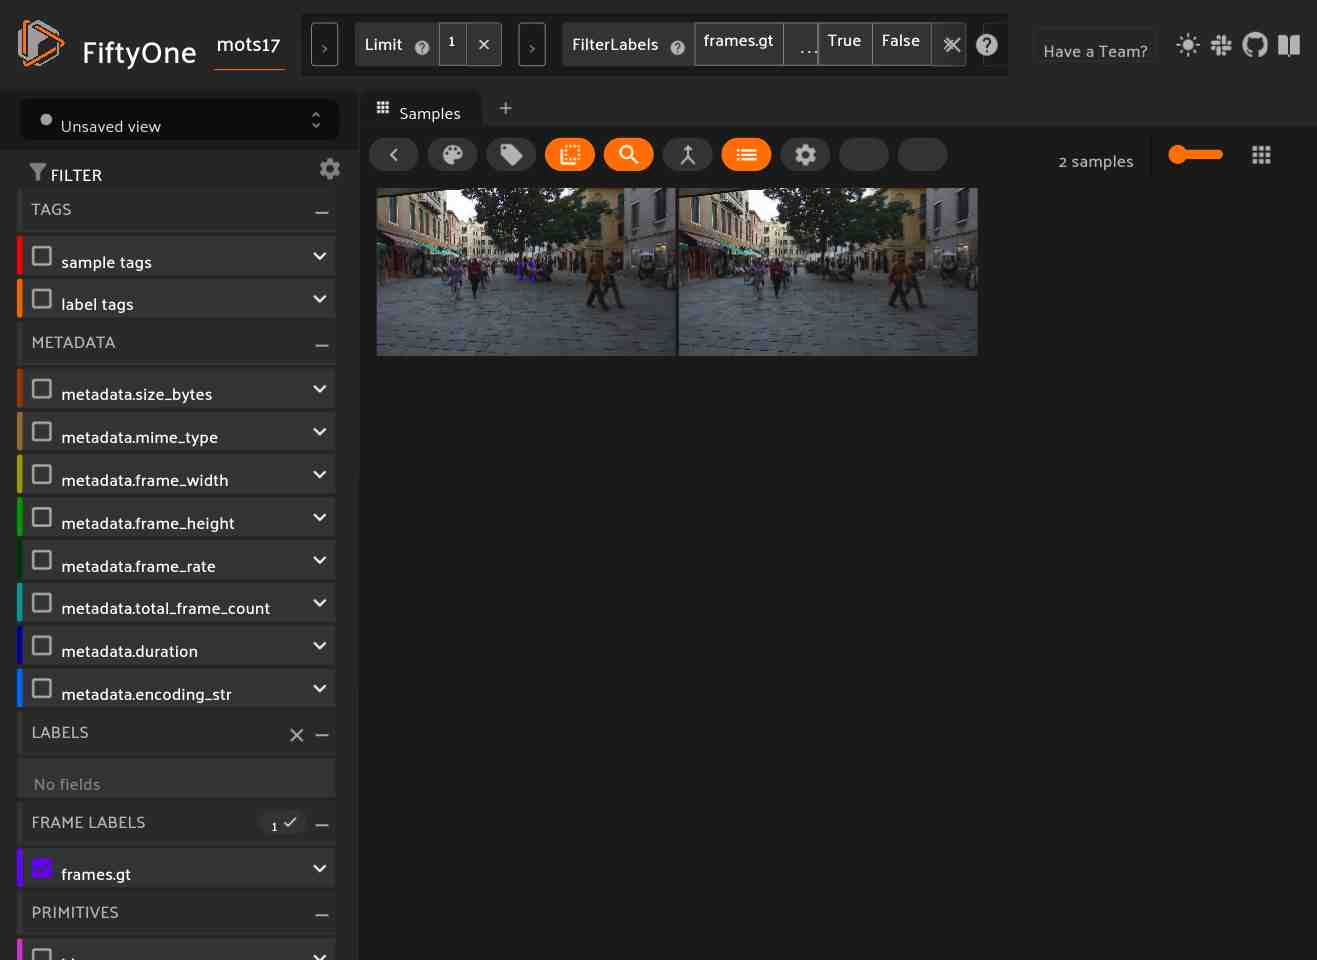

In [11]:
session.view = trajectories

The slowest trajectory is a person who is sitting down! In retrospect, this is not so surprising. In the original ground-truth labels, this person was probably labeled as ‘Person static’.
The fastest pedestrian speeds by the camera in the foreground.

## Tracking with YOLOv8 + BoT-SORT

Let’s do some tracking! We’ll use [Ultralytics tracking](https://docs.ultralytics.com/modes/track) to generate some object tracking predictions. This combines object detection using YOLOv8 with a second stage where detections are associated into trajectories.

First, we’ll install the ultralytics package. Note that you may need to install `python3.x-dev` on your system in order to complete this installation.

In [ ]:
!pip install ultralytics

In [12]:
import ultralytics

In [ ]:
view = dataset.skip(1)
mov_track = view.first().filepath
print(f'Tracking movie {mov_track}')
model = ultralytics.YOLO('yolov8n.pt')
results = model.track(mov_track,show=False)

Let’s load our tracking results! The tracker has output detections in a csv and we will load them as we did with the groundtruth trajectories.

In [14]:
imw = view.first().metadata.frame_width
imh = view.first().metadata.frame_height

for frm,resobj in enumerate(results):
    f = view.first().frames[frm+1]
    try:
        if f.yolo8 is None:
            f.yolo8 = fo.Detections()
    except AttributeError:
            f['yolo8'] = fo.Detections()
        
    boxes = resobj.boxes
    is_person = boxes.cls.numpy() == 0
    bxs = boxes.data.numpy()[is_person]
    for b in bxs:
        bb = b[:4].tolist()
        bb = [bb[0]/imw, bb[1]/imh, (bb[2]-bb[0])/imw, (bb[3]-bb[1])/imh]
        idx = int(b[4])
        conf = float(b[5])
        det = fo.Detection(label='person',bounding_box=bb,index=idx,confidence=conf)
        f.yolo8.detections.append(det)
        f.save()
        
    if frm % 50==0:
        print(f'frame {frm}, {len(bxs)} detections')

frame 0, 5 detections
frame 50, 6 detections
frame 100, 5 detections
frame 150, 5 detections
frame 200, 8 detections
frame 250, 7 detections
frame 300, 6 detections
frame 350, 4 detections
frame 400, 5 detections
frame 450, 6 detections
frame 500, 7 detections


In [24]:
session.view = view

## Evaluate Our Tracking

The tracker has generated detections and also stitched them into trajectories, typically by utilizing some combination of a motion and appearance/reID model. How can we gain insight into the quality of the tracking?

One step is to evaluate false positive and false negative detections. This can be done using FiftyOne’s built-in evaluate_detections method, which supports video datasets and will compute evaluation statistics on frame-level detections.

For multiple object tracking in video, false positive and false negative detections do not tell the whole story. Various metrics (see eg [TrackEval](https://github.com/JonathonLuiten/TrackEval) can be defined to assess different aspects of this problem. We’ll leave a deep dive into this type of evaluation for another time. Here, we focus on finding identity swaps in the tracking. One type of identity swap occurs when a predicted trajectory jumps from one individual to another. This can occur when two trajectories cross paths and occlude each other, for example. (We use the term “identity swap” informally; more careful definitions can be made, eg in [this article](https://link.springer.com/article/10.1007/s11263-020-01375-2)).

One of FiftyOne’s strengths when working with video is that it is easy to switch between data modalities. We can convert full videos to individual clips, for instance, or from videos to images. In this next analysis, we’ll convert our tracked video to individual frames and work with image samples.

Since we only included people during tracking, we’ll filter our view to include only the `person` class from the ground_truth.

Then, we’ll call `to_frames` which will convert our view to an image/frame-based dataset.

In [17]:
from fiftyone import ViewField as F

view_frames = view.to_frames(sample_frames=True) \
    .filter_labels('gt',F('label').is_in(['person','person_static']))
ds_frames = view_frames.clone()
ds_frames.name = view_frames.dataset_name + '_frames_yt'
ds_frames.persistent = True

As a sanity check, how many trajectories do we have?

In [18]:
print(len(ds_frames.distinct('gt.detections.index')))
print(len(ds_frames.distinct('yolo8.detections.index')))

27
11


To investigate identity swaps, predicted and ground truth trajectories must be associated with each other, as their trajectory indices have been generated independently. We’ll do a very simple greedy matching process for illustrative purposes. A more [rigorous approach](https://link.springer.com/article/10.1007/s11263-020-01375-2)  might use the [Hungarian algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm) to match detections, or even entire trajectories.

We’ll take the midpoint of each predicted trajectory and look for the ground truth bounding box that minimizes an L2 distance with the predicted bounding box in that frame. We assign that ground truth index to the predicted trajectory for all of its frames. We use the midpoint of the trajectory rather than its endpoints, as trajectory endpoints may involve more noise due to occlusions
or people entering/exiting the scene.

In [19]:
yolo_to_gt = {}
idxs = ds_frames.distinct('yolo8.detections.index')
for idx in idxs:
    frms = ds_frames.filter_labels('yolo8',F('index')==idx,only_matches=True) \
        .values('frame_number')
    mid_idx = len(frms) // 2
    frm_mid = frms[mid_idx]
    
    samp_mid = ds_frames.match(F('frame_number')==frm_mid)
    assert len(samp_mid)==1
    
    gt_bbs,gt_idxs = samp_mid.values(['gt.detections.bounding_box', 'gt.detections.index'])
    gt_bbs = gt_bbs[0]
    gt_idxs = gt_idxs[0]
    bbs_gt = np.array(gt_bbs)
    bbs_gt[:,2] += bbs_gt[:,0]
    bbs_gt[:,3] += bbs_gt[:,1]
    
    bb_pred = samp_mid.filter_labels('yolo8',F('index')==idx).values('yolo8.detections.bounding_box')
    assert len(bb_pred)==1
    bb = np.array(bb_pred[0])
    bb[:,2] += bb[:,0]
    bb[:,3] += bb[:,1]
    
    dists = np.linalg.norm(bbs_gt-bb,axis=1)
    gt_idx_argmin = np.argmin(dists)
    gt_idx = gt_idxs[gt_idx_argmin]
    yolo_to_gt[idx] = gt_idx
    print(f'Frame {frm_mid}: Yolo index {idx} -> GT index {gt_idx}, dist is {dists[gt_idx_argmin]:.2f}')

Frame 263: Yolo index 1 -> GT index 29, dist is 0.01
Frame 263: Yolo index 2 -> GT index 13, dist is 0.01
Frame 263: Yolo index 3 -> GT index 8, dist is 0.02
Frame 269: Yolo index 4 -> GT index 13, dist is 0.02
Frame 263: Yolo index 5 -> GT index 12, dist is 0.01
Frame 281: Yolo index 6 -> GT index 18, dist is 0.01
Frame 266: Yolo index 7 -> GT index 21, dist is 0.01
Frame 249: Yolo index 8 -> GT index 22, dist is 0.01
Frame 243: Yolo index 9 -> GT index 22, dist is 0.01
Frame 232: Yolo index 10 -> GT index 62, dist is 0.11
Frame 234: Yolo index 11 -> GT index 62, dist is 0.18


We now update our labels to account for the trajectory index. In effect, we create classes like `person00` , `person01` , etc based on the tracked individuals. With the classes updated in this way, we can run FiftyOne’s object detection evaluation out of the box.

In [20]:
for s in ds_frames:
    for det in s.gt.detections:
        det.label = f'{det.label}{det.index:02}'
    for det in s.yolo8.detections:
        new_index = yolo_to_gt[det.index]
        det.label = f'{det.label}{new_index:02}'
    s.save()

In [21]:
eval_res = ds_frames.evaluate_detections('yolo8',gt_field='gt',eval_key='eval')

Evaluating detections...
 100% |█████████████████| 525/525 [6.4s elapsed, 0s remaining, 80.2 samples/s]       


In the [evaluation patches view](https://docs.voxel51.com/user_guide/app.html#viewing-evaluation-patches), false positives often represent an identity swap where the assigned and ground truth individuals (classes) do not match.

Let’s examine evaluation patches that are false positives. For simplicity we focus on large detections where the bounding box exceeds a certain size.

In [22]:
view_eval = ds_frames.to_evaluation_patches(eval_key='eval',config=None)
bbox_area = F('bounding_box')[2] * F('bounding_box')[3]
large_boxes = F('yolo8.detections').filter(bbox_area>0.05)
view_eval_fps_large = view_eval.match(F('type')=='fp').match(large_boxes.length()>0)


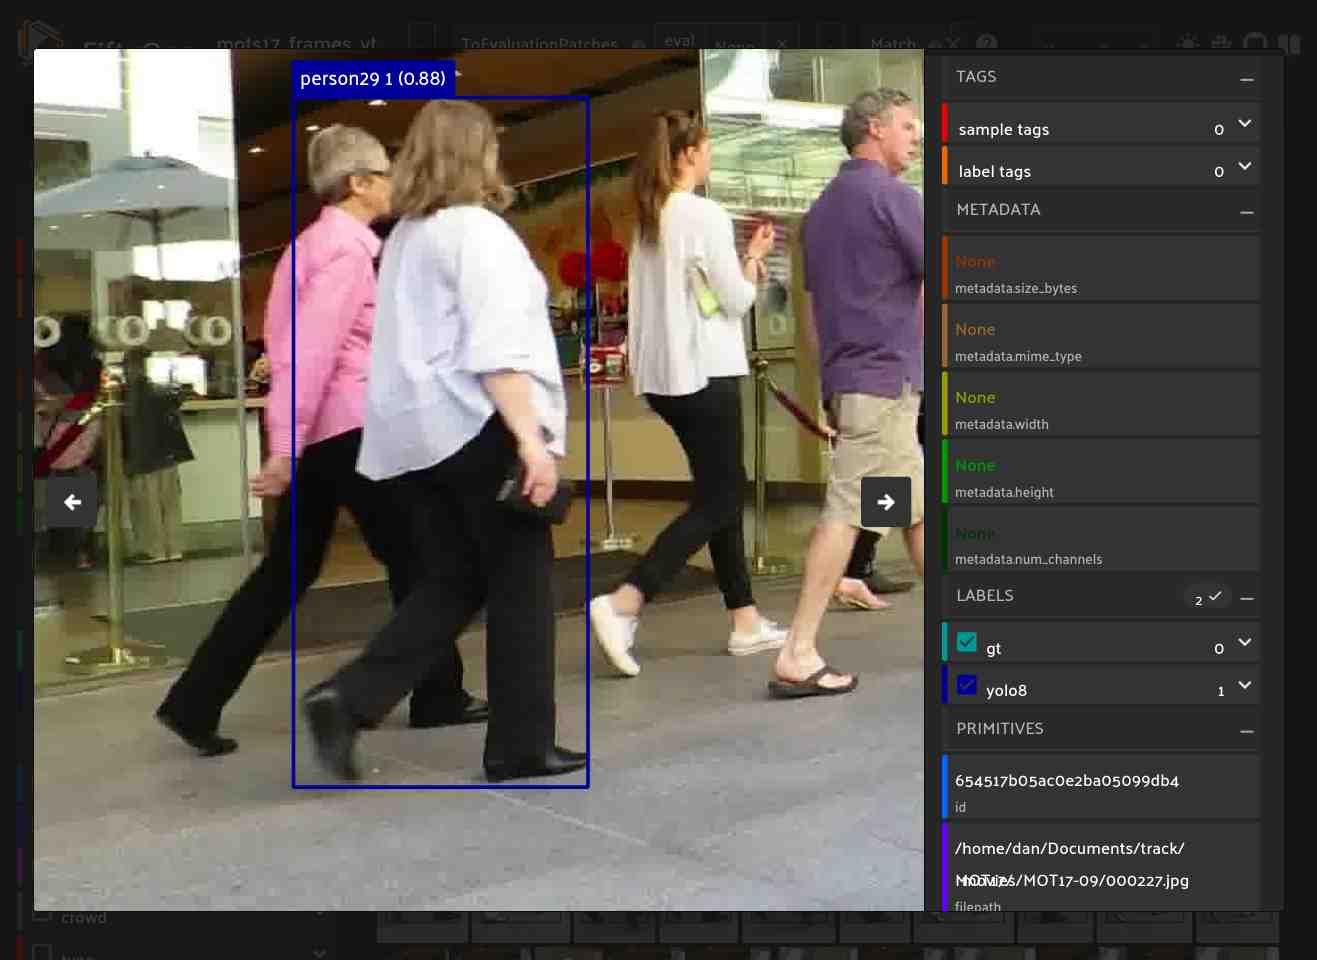

In [23]:
session.view = view_eval_fps_large

In [28]:
SUSP_YOLO_IDXS = [1,29,69] # Indices identified browsing in the FiftyOne App. Tracking results may be stochastic to some extent
trajectories = view.filter_labels("frames.yolo8", F("index").is_in(SUSP_YOLO_IDXS)).to_trajectories("frames.yolo8")

In [29]:
session.view = trajectories